<a href="https://colab.research.google.com/github/Javsk891/proyecto-integrador-2/blob/main/EDA_Volador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Instalación de librerías
!pip install arch
!pip install pandas-profiling
!pip install --upgrade Pillow
!pip install ydata-profiling


# Análisis Exploratorio de los Datos - **EDA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
from ydata_profiling import ProfileReport #Perfilamiento de datos
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
#Cargar el dataframe
path = '/content/drive/MyDrive/EAFIT/Semestre 2/Proyecto Integrador/Calidad del Aire/'
volador = pd.read_csv(path+"volador_b.csv")
# Eliminar la columna "Unnamed: 0"
volador.drop(columns=["Unnamed: 0"], inplace=True)
volador.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63073 entries, 0 to 63072
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fecha                   63073 non-null  object 
 1   Nombre de la estación   63073 non-null  object 
 2   Latitud                 63073 non-null  float64
 3   Longitud                63073 non-null  float64
 4   Nombre del municipio    63073 non-null  object 
 5   Dirección del Viento    49484 non-null  float64
 6   Humedad Relativa 10 m   49547 non-null  float64
 7   Humedad Relativa 2 m    2722 non-null   float64
 8   NO                      41418 non-null  float64
 9   NO2                     41761 non-null  float64
 10  O3                      40862 non-null  float64
 11  PM2.5                   52250 non-null  float64
 12  Precipitación Líquida   27387 non-null  float64
 13  Presión Atmosférica     55328 non-null  float64
 14  Radiación Solar Global  45586 non-null

In [ ]:
# Formatear fecha
volador["Fecha"] = pd.to_datetime(volador["Fecha"], format="%Y-%m-%d %H:%M:%S")
volador.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63073 entries, 0 to 63072
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Fecha                   63073 non-null  datetime64[ns]
 1   Nombre de la estación   63073 non-null  object        
 2   Latitud                 63073 non-null  float64       
 3   Longitud                63073 non-null  float64       
 4   Nombre del municipio    63073 non-null  object        
 5   Dirección del Viento    49484 non-null  float64       
 6   Humedad Relativa 10 m   49547 non-null  float64       
 7   Humedad Relativa 2 m    2722 non-null   float64       
 8   NO                      41418 non-null  float64       
 9   NO2                     41761 non-null  float64       
 10  O3                      40862 non-null  float64       
 11  PM2.5                   52250 non-null  float64       
 12  Precipitación Líquida   27387 non-null  float6

# Perfilamiento de Datos

In [ ]:
# Estadistica descriptiva del dataset
# Seleccionar variables numéricas
numeric_cols = volador.select_dtypes(include=["int64", "float64"]).columns
numeric_cols = [col for col in numeric_cols if col not in ["Nombre de la estación", "Latitud", "Longitud"]]

# Calcular estadísticas descriptivas
descriptive_stats = volador[numeric_cols].describe(percentiles=[.25, .5, .75]).transpose()

# Añadir moda y rango intercuartílico
# Calculate mode for each column separately and store in a list
modes = [volador[col].mode()[0] if not volador[col].mode().empty else None for col in numeric_cols]
descriptive_stats["Moda"] = modes # Assign the list of modes to the "Moda" column
descriptive_stats["Rango Intercuartílico"] = descriptive_stats["75%"] - descriptive_stats["25%"]

# Mostrar estadísticas descriptivas
print(descriptive_stats.to_string())

# Crear dataframe con estadísticas descriptivas
descriptive_stats_df = pd.DataFrame(descriptive_stats)



                          count        mean         std         min         25%         50%         75%          max        Moda  Rango Intercuartílico
Dirección del Viento    49484.0  127.942170  121.948402    0.001588   27.813170   62.113205  263.441750   359.997150  259.005000             235.628580
Humedad Relativa 10 m   49547.0   67.040752   17.936912   11.550070   52.519595   71.867400   81.598100    96.815700   94.200000              29.078505
Humedad Relativa 2 m     2722.0   66.765834   16.768315   22.100000   52.600000   71.900000   79.600000    96.400000   75.600000              27.000000
NO                      41418.0   29.032907   33.132864    0.000375    7.323363   15.944048   37.544283   347.853125    2.452930              30.220920
NO2                     41761.0   36.025473   16.580452    0.002089   24.780973   33.413513   44.050406   157.055246   22.565390              19.269433
O3                      40862.0   23.952013   23.088926    0.000439    6.380192   17.021

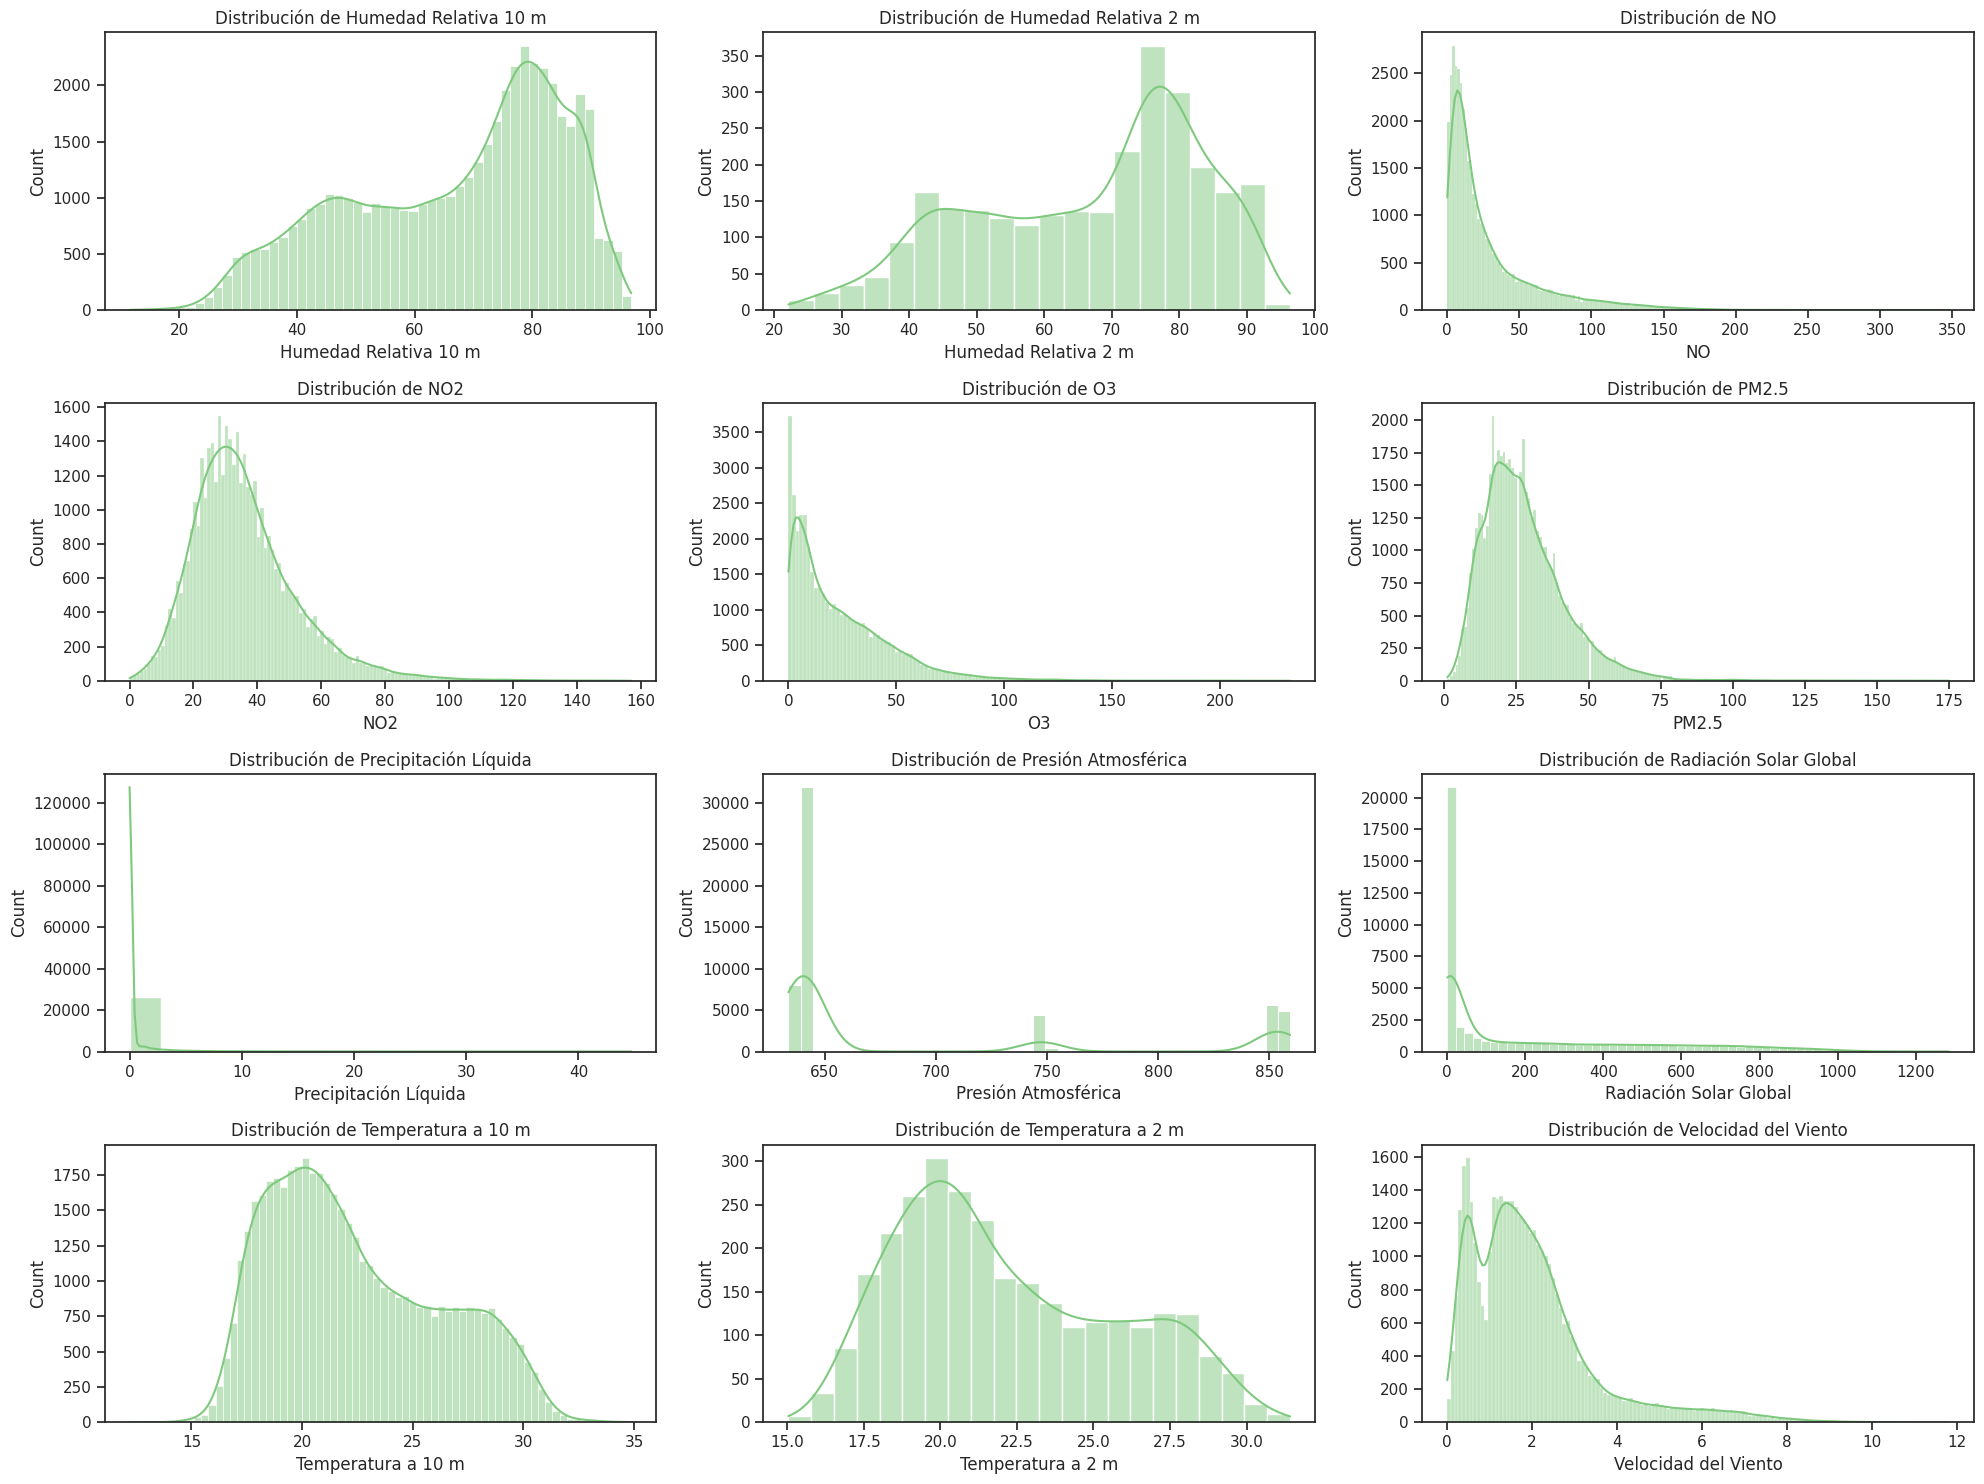

In [ ]:
#Graficos de distribucion
# Crear una figura con subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

# Lista de variables a plotear
variables = ['Humedad Relativa 10 m', 'Humedad Relativa 2 m', 'NO', 'NO2', 'O3', 'PM2.5',
             'Precipitación Líquida', 'Presión Atmosférica', 'Radiación Solar Global',
             'Temperatura a 10 m', 'Temperatura a 2 m', 'Velocidad del Viento']

# Iterar sobre las variables y los ejes
for ax, variable in zip(axes.flatten(), variables):
    sns.histplot(data=volador, x=variable, kde=True, ax=ax)
    ax.set_title(f'Distribución de {variable}')

# Ajustar el layout
plt.tight_layout()

# Mostrar la gráfica
plt.show()

<ipython-input-99-effe0d937a9e>:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




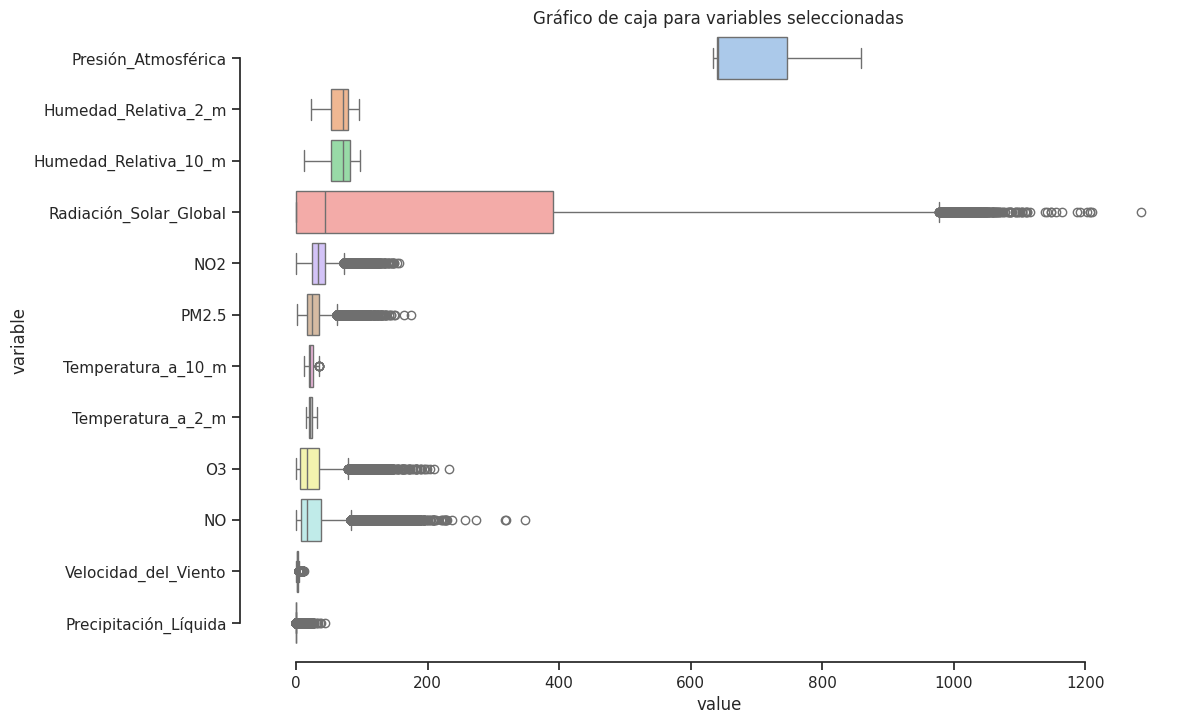

In [ ]:
#Generacción de BoxPlots de datos

# Configurar el tema de seaborn
sns.set_theme(style="ticks", palette='Accent')

# Renombrar columnas para evitar problemas con espacios
volador_filtered = volador.rename(columns=lambda x: x.strip().replace(' ', '_'))

# Verificar los nombres de las columnas después de renombrarlas
#print(volador_filtered.columns)

# Seleccionar columnas especificadas con los nombres correctos
cols = [
    'CO', 'Humedad_Relativa', 'Humedad_Relativa_10_m', 'Humedad_Relativa_2_m',
    'NO', 'NO2', 'O3', 'PM10', 'PM2.5', 'Precipitación_Líquida', 'Presión_Atmosférica',
    'Radiación_Solar_Global', 'SO2', 'Temperatura', 'Temperatura_a_10_m', 'Temperatura_a_2_m',
    'Velocidad_del_Viento'
]

# Filtrar el DataFrame para incluir solo las columnas seleccionadas que existen y tienen datos
existing_cols = [col for col in cols if col in volador_filtered.columns and volador_filtered[col].notna().any()]

# Convertir a formato largo para seaborn
volador_long = volador_filtered.melt(value_vars=existing_cols, var_name='variable', value_name='value')

# Ordenar las variables en orden descendente basado en la mediana de los valores
order = volador_long.groupby('variable')['value'].median().sort_values(ascending=False).index

# Crear gráfico de caja con barras dispuestas horizontalmente
plt.figure(figsize=(12, 8))
sns.boxplot(y='variable', x='value', data=volador_long, order=order, palette="pastel")
sns.despine(offset=10, trim=True)
plt.title('Gráfico de caja para variables seleccionadas')
plt.show()

## Perfilamiento empleando el API pandas profiling (ydata-profiling) con el fin de realizar un EDA de los datos de forma automática

In [ ]:
#Perfilamiento de datos
profile = ProfileReport(volador, title="REporte de Perfilamiento de datos", correlations={"auto": {"calculate": False}}, missing_diagrams={"Heatmap": True})
profile.to_file(path+"perfil_datos_volador.html")
profile


In [ ]:
volador.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63073 entries, 0 to 63072
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Fecha                   63073 non-null  datetime64[ns]
 1   Nombre de la estación   63073 non-null  object        
 2   Latitud                 63073 non-null  float64       
 3   Longitud                63073 non-null  float64       
 4   Nombre del municipio    63073 non-null  object        
 5   Dirección del Viento    49484 non-null  float64       
 6   Humedad Relativa 10 m   49547 non-null  float64       
 7   Humedad Relativa 2 m    2722 non-null   float64       
 8   NO                      41418 non-null  float64       
 9   NO2                     41761 non-null  float64       
 10  O3                      40862 non-null  float64       
 11  PM2.5                   52250 non-null  float64       
 12  Precipitación Líquida   27387 non-null  float6

# Pairplots y Correlaciones
Muestra graficamente, correlaciones entre pares de variables

In [ ]:
x_vars=["PM2.5", "NO", "NO2"]
y_vars=["O3", "Humedad Relativa 10 m", "Humedad Relativa 2 m","Radiación Solar Global", "Dirección del Viento", "Velocidad del Viento"]

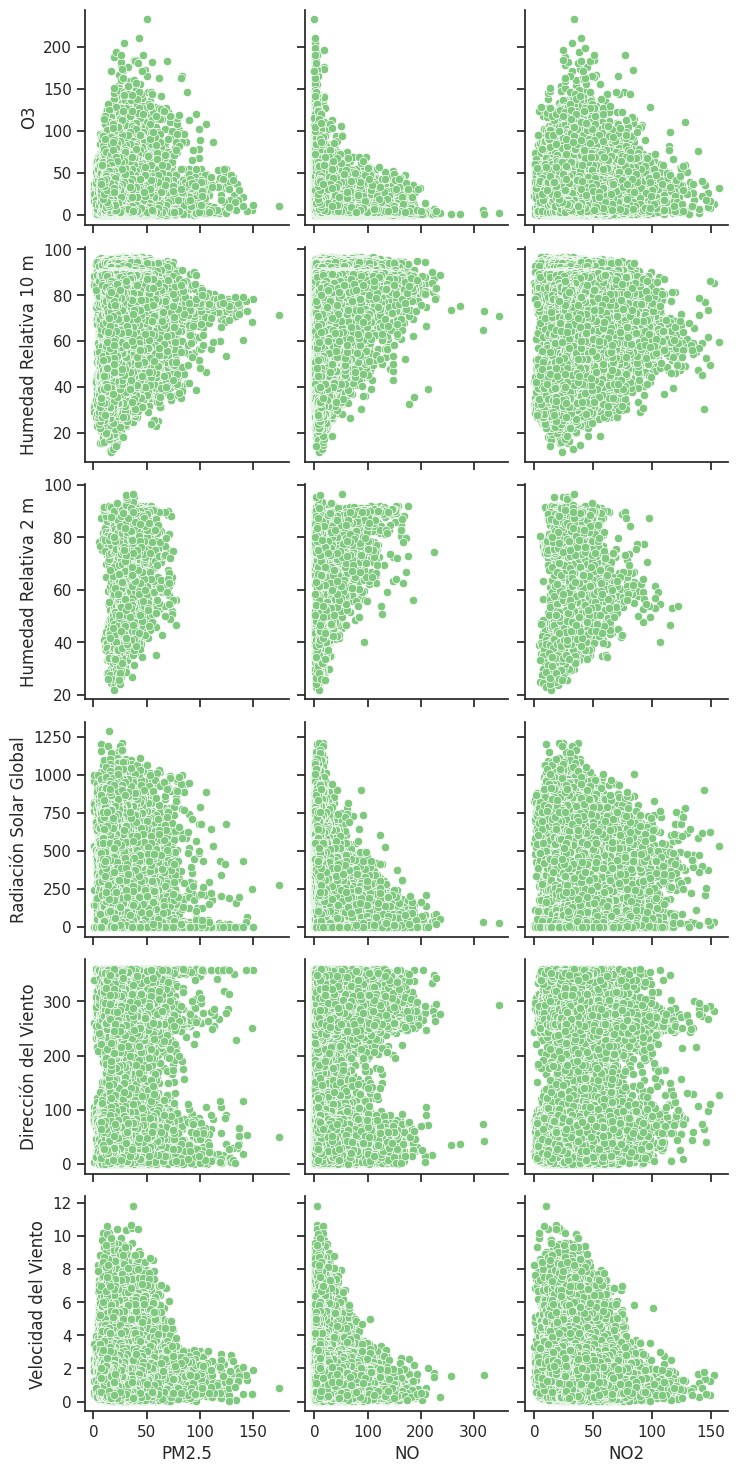

In [ ]:
# Pairplots entre variables de "Contaminantes" y Variables amientales
sns.pairplot(volador, x_vars=x_vars, y_vars=y_vars)

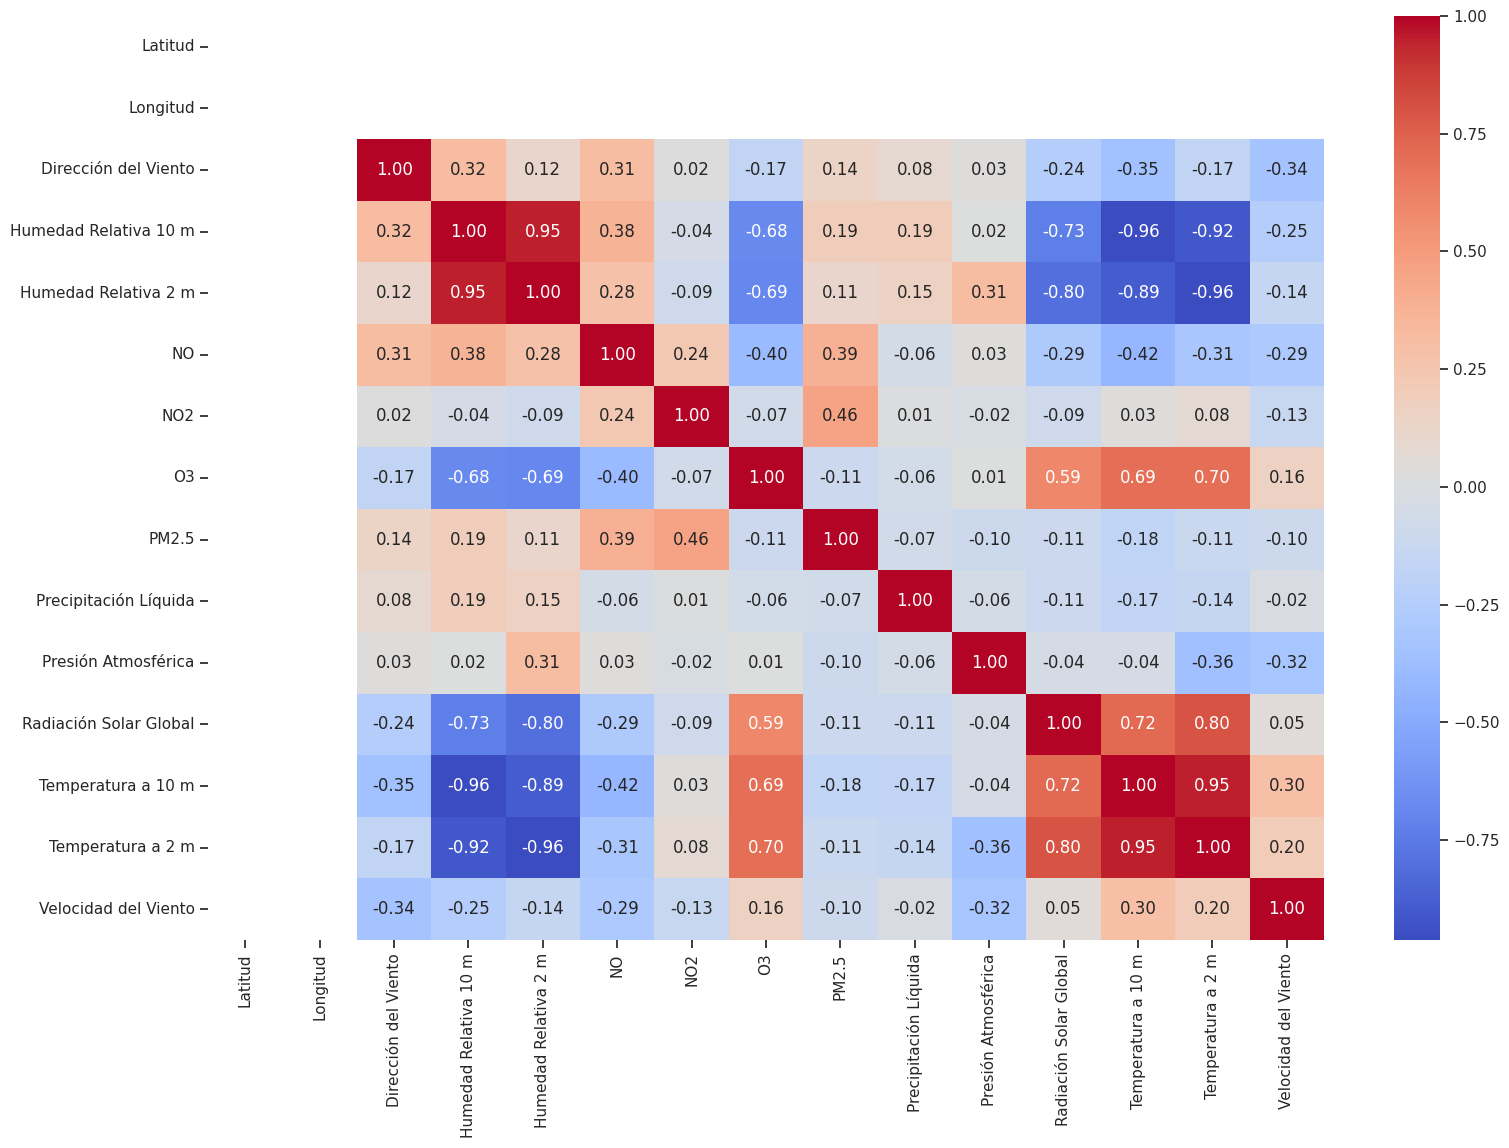

In [ ]:
#  Análisis de correlaciones - Heatmap

# Obtener las variables numéricas del dataframe amva
numeric_variables = volador.select_dtypes(include=['int64', 'float64']).columns

# Calcular la matriz de correlación
correlation_matrix = volador[numeric_variables].corr()

# Crear el heatmap
fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=ax, cmap="coolwarm")

# Mostrar el heatmap
plt.show()


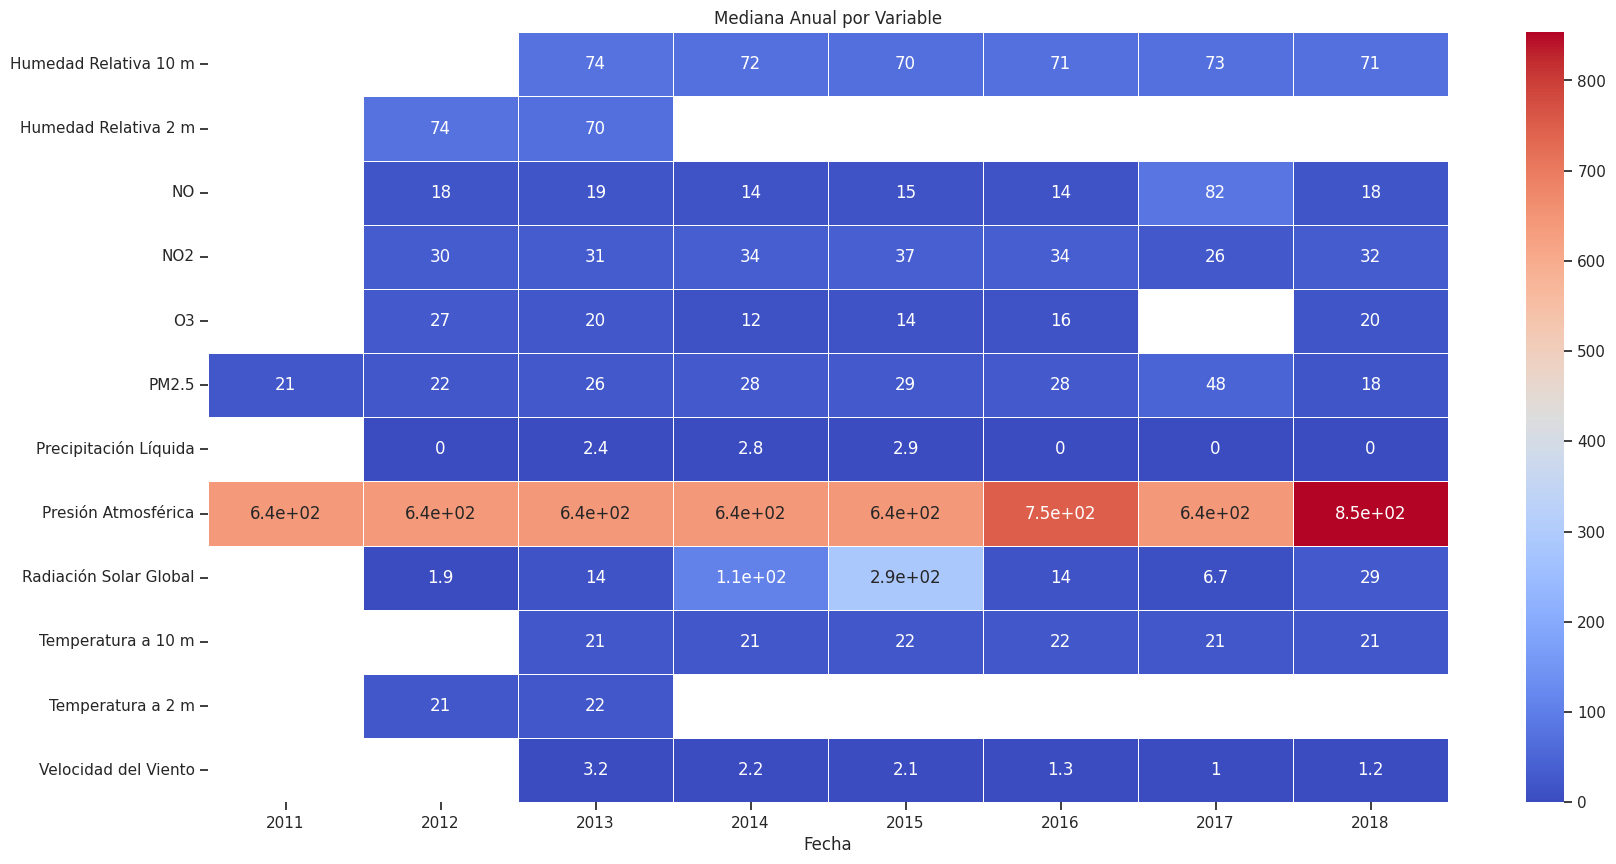

In [ ]:
# Calcular la mediana anual por cada variable
# Select only numeric columns
numeric_columns = volador.select_dtypes(include=np.number).columns
medianas_anuales = volador[numeric_columns].groupby(volador['Fecha'].dt.year).median()

# Seleccionar las variables numéricas para el mapa de calor
variables_numericas = ['Humedad Relativa 10 m', 'Humedad Relativa 2 m', 'NO', 'NO2', 'O3', 'PM2.5',
                       'Precipitación Líquida', 'Presión Atmosférica', 'Radiación Solar Global',
                       'Temperatura a 10 m', 'Temperatura a 2 m', 'Velocidad del Viento']

# Filtrar las columnas numéricas existentes en el DataFrame
variables_numericas = [col for col in variables_numericas if col in medianas_anuales.columns]

# Configurar el tamaño de la figura
plt.figure(figsize=(20, 10))

# Crear el mapa de calor
sns.heatmap(medianas_anuales[variables_numericas].transpose(), annot=True, linewidths=.5, cmap='coolwarm')

# Título del gráfico
plt.title('Mediana Anual por Variable')

# Mostrar el gráfico
plt.show()


In [ ]:
# Generar una matriz mostrando los valores nulos del dataframe volador
fig = px.imshow(volador.isnull(),
              x=volador.columns,
              y=volador.index)
fig.show()


## **Análisis de la serie de tiempo PM2.5**

In [ ]:
#Gràfico de la Serie temporalb sin acotar

fig = px.line(volador, x ='Fecha',  y='PM2.5', title='Concentración de PM2.5 en la estación MED-UN Núcleo Volador')

# Crear un slider para filtrar por fecha
fig.update_xaxes(rangeslider_visible=True)

# Mostrar el gráfico
fig.show()


In [ ]:
# verificar la existencia de valores nulos antes de eliminar registros
null_count_before = volador_pm25.isnull().sum()

# Eliminar registros donde 'PM2.5' is nulo
volador_pm25 = volador_pm25.dropna(subset=['PM2.5'])

# Verificar el numero de registros final luego de eliminar los registros nulos
null_count_after = volador_pm25.isnull().sum()


print("Null values before dropping rows:")
print(null_count_before)
print("\nNull values after dropping rows:")
print(null_count_after)


Null values before dropping rows:
Fecha    0
PM2.5    0
dtype: int64

Null values after dropping rows:
Fecha    0
PM2.5    0
dtype: int64


Se observa un intervalo de datos nulos de 1 año completo entre enero 2017 y enero 2018, por lo cual la evaluacion se podría realizar eliminando dicho intervalo (dropna())

In [ ]:

#Gràfico de la Serie temporalb sin acotar

fig = px.line(volador_pm25, x ='Fecha',  y='PM2.5', title='Concentración de PM2.5 en la estación MED-UN Núcleo Volador luego de eliminar registros nulos')

# Crear un slider para filtrar por fecha
fig.update_xaxes(rangeslider_visible=True)

# Mostrar el gráfico
fig.show()

"Se define trabajar con una ventana de tiempo desde septiembre 18 de 2012 hasta 01 enero 2016.

In [ ]:
#Filtrar el dataframe 'volador' que solo contenga los registros desde septiembre 18 de 2012 hasta 31 diciembre 2016.

volador_w = volador[(volador['Fecha'] >= '2012-09-18') & (volador['Fecha'] <= '2016-01-01')]

#Gráfico de la ventana de datos
fig = px.line(volador_w, x = 'Fecha', y='PM2.5', title='Concentración de PM2.5 en la estación MED-UN Núcleo Volador')

# Crear un slider para filtrar por fecha
fig.update_xaxes(rangeslider_visible=True)

# Mostrar el gráfico
fig.show()

In [ ]:
volador_w.to_csv(path+'volador_ventana.csv') #Dataset para los modelos

In [ ]:
# prompt: eliminar NaN de PM2.5_series




<Figure size 1200x600 with 0 Axes>

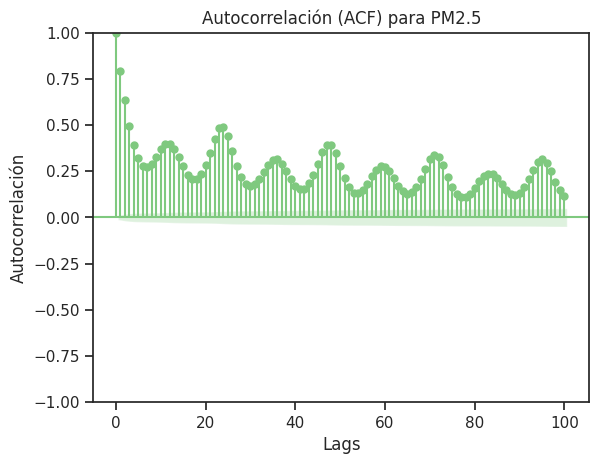

<Figure size 1200x600 with 0 Axes>

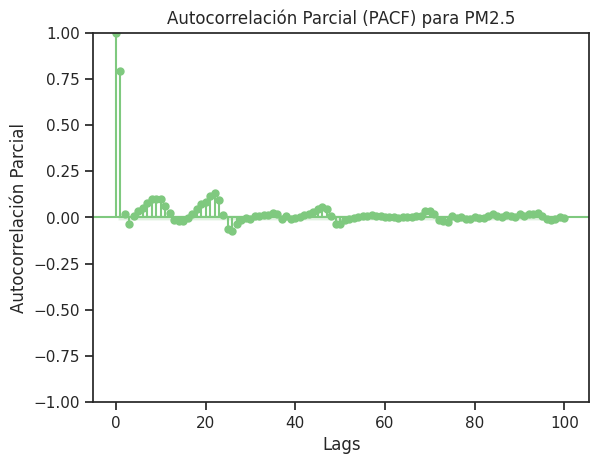

In [ ]:
# Seleccionar la serie de tiempo de PM2.5 para el análisis
pm25_series = volador_w['PM2.5'].dropna()


# Graficar la Autocorrelación (ACF)
plt.figure(figsize=(12, 6))

# Definir el numero de retrasos
plot_acf(pm25_series, lags=100)
plt.title('Autocorrelación (ACF) para PM2.5')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.show()

# Graficar la Autocorrelación Parcial (PACF)
plt.figure(figsize=(12, 6))

## Definir el numero de retrasos
plot_pacf(pm25_series, lags=100)
plt.title('Autocorrelación Parcial (PACF) para PM2.5')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.show()


In [ ]:
# Realizar la prueba de Dickey-Fuller aumentada (ADF)
result = adfuller(pm25_series)
print('Estadística de la prueba ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])
print('Número de lags utilizados:', result[2])
print('Número de observaciones utilizadas:', result[3])
print('Significancia estadística:', result[1] < 0.05)


Estadística de la prueba ADF: -11.245114704376789
Valor p: 1.7674915663922157e-20
Valores críticos: {'1%': -3.430592632740003, '5%': -2.861647236667565, '10%': -2.566827078883082}
Número de lags utilizados: 49
Número de observaciones utilizadas: 26954
Significancia estadística: True


Teniendo en cuenta que p< 0.05, se rechaza la hipótesis nula de la prueba de Dickey-Fuller aumentada (ADF). Por lo tanto, se puede concluir que la serie temporal de PM2.5 es estacionaria.

Se observa patrones repetitivos en los picos de la ACF , con perídos de 12 horas (dia) y valor maximo en el período 6; asimismo en la PACFp; Por lo anterior se puede concluír que la serie es estacional

In [ ]:
# Descomposicion de la serie temporal PM2.5 en tendencia, estacionalidad y residuos

from plotly.subplots import make_subplots

# Descomposición de la serie de tiempo PM2.5
decomposition = seasonal_decompose(pm25_series, period=24, model='additive')

# Crear subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=("Original", "Tendencia", "Estacionalidad", "Residuos"))

# Agregar trazas a los subplots
fig.add_trace(go.Scatter(x=pm25_series.index, y=pm25_series, name="Original"), row=1, col=1)
fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, name="Tendencia"), row=2, col=1)
fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, name="Estacionalidad"), row=3, col=1)
fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, name="Residuos"), row=4, col=1)

# Actualizar el diseño del gráfico
fig.update_layout(height=1200, title_text="Descomposición de la serie de tiempo PM2.5")

# Mostrar el gráfico
fig.show()
